In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np  #0 white 1 black 2 chinese 3 indian 4 hispanic
import pandas as pd
import cv2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import asarray 
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.transforms import ToPILImage, ToTensor
import re
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import classification_report
import gc
torch.cuda.empty_cache()
gc.collect()

#for dirname, _, filenames in os.walk('/kaggle/input/utkface-new/UTKFace'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))   
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2442

In [26]:
DATA_DIR = "/kaggle/input/utkface-new/UTKFace"
TRAIN_TEST_SPLIT = 0.7
IM_WIDTH = IM_HEIGHT = 198
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = dict((g, i) for i, g in ID_GENDER_MAP.items())
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = dict((r, i) for i, r in ID_RACE_MAP.items())

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [27]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print(filepath)
        return None, None, None

In [28]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

/kaggle/input/utkface-new/UTKFace/61_1_20170109142408075.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/61_1_20170109150557335.jpg.chip.jpg
/kaggle/input/utkface-new/UTKFace/39_1_20170116174525125.jpg.chip.jpg


In [29]:
df = pd.DataFrame(attributes)
df['file'] = files
df.columns = ['age', 'gender', 'race', 'file']
df = df.dropna()
df.head()

,age,gender,race,file
0,26.0,male,asian,/kaggle/input/utkface-new/UTKFace/26_0_2_20170...
1,22.0,female,black,/kaggle/input/utkface-new/UTKFace/22_1_1_20170...
2,21.0,female,indian,/kaggle/input/utkface-new/UTKFace/21_1_3_20170...
3,28.0,male,white,/kaggle/input/utkface-new/UTKFace/28_0_0_20170...
4,17.0,female,others,/kaggle/input/utkface-new/UTKFace/17_1_4_20170...


In [30]:
# Under-sample the 'white' class
white_df = df[df['race'] == 'white']
non_white_df = df[df['race'] != 'white']

In [31]:
# Set the desired count, for instance, let's equalize it to the count of the 'black' class for demonstration purposes
desired_white_count = df[df['race'] == 'black'].shape[0]
white_df = white_df.sample(n=desired_white_count, random_state=42)

# Under-sample age values of 26
age_26_df = df[df['age'] == 26]
non_age_26_df = df[df['age'] != 26]

# Set the desired count, let's take the median of the age counts for demonstration
median_age_count = int(df['age'].value_counts().median())
age_26_df = age_26_df.sample(n=median_age_count, random_state=42)

In [32]:
# Concatenate the separate DataFrames back together
df = pd.concat([white_df, non_white_df, age_26_df, non_age_26_df])

In [33]:
# Shuffle the DataFrame rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [34]:
# from imblearn.over_sampling import SMOTE

# # Convert gender and race to numerical values for the SMOTE operation
# df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
# df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

# # Extract features excluding 'file' and target variable
# X = df[['age', 'gender_id']]
# y = df['race_id']

# # Store the file column separately to join it later
# file_column = df['file']

# # Initialize SMOTE
# smote = SMOTE(sampling_strategy={RACE_ID_MAP['others']: desired_white_count}, random_state=42)

# # Apply SMOTE to our data
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Create a new DataFrame from the resampled data
# df_resampled = pd.DataFrame(X_resampled, columns=['age', 'gender_id'])
# df_resampled['race_id'] = y_resampled

# # Map back the race_id and gender_id to their categorical values
# df_resampled['race'] = df_resampled['race_id'].map(lambda race_id: ID_RACE_MAP[race_id])
# df_resampled['gender'] = df_resampled['gender_id'].map(lambda gender_id: ID_GENDER_MAP[gender_id])

# # Join the 'file' column back to the df_resampled DataFrame. 
# # Note: This action simply repeats the file paths for the oversampled rows.
# # If this is not the desired behavior, further processing might be necessary.
# df_resampled = df_resampled.join(file_column)

In [35]:
df.describe()

,age
count,39808.000000
mean,33.028311
std,19.960382
min,1.000000
25%,22.000000
50%,30.000000
75%,45.000000
max,116.000000


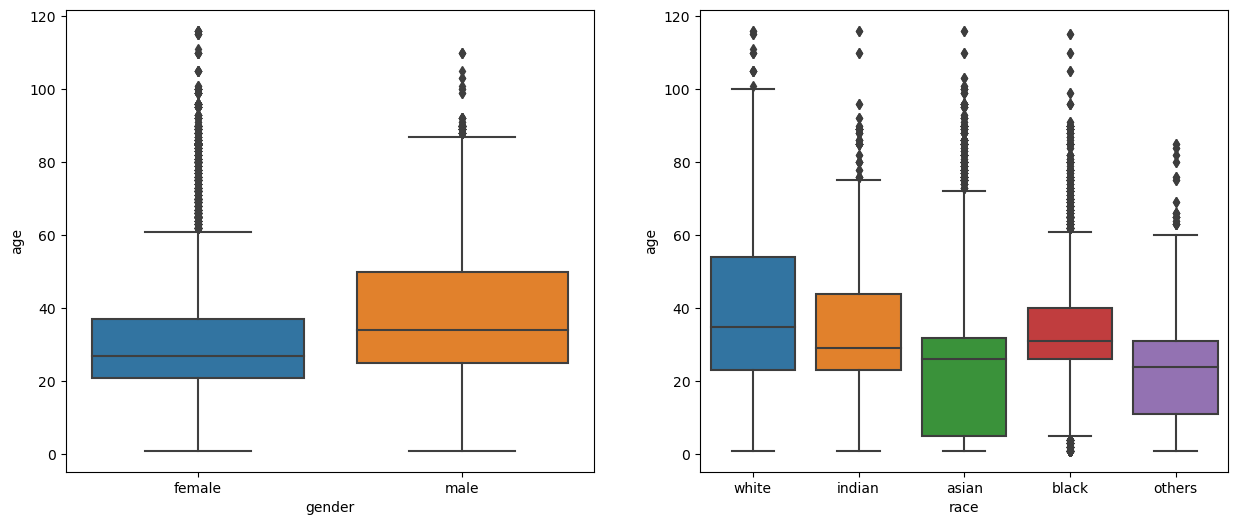

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

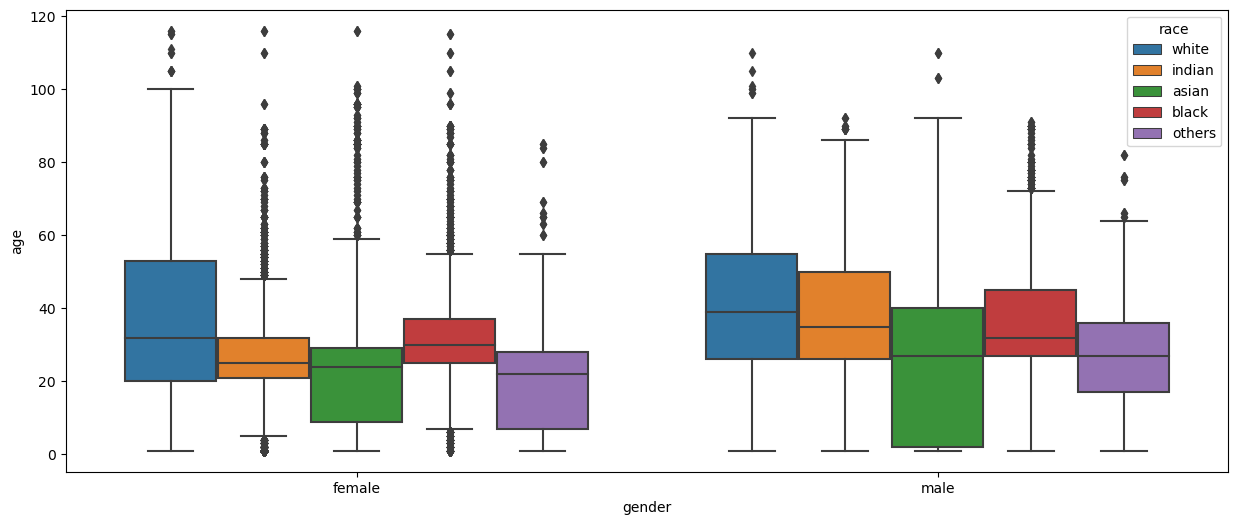

In [37]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

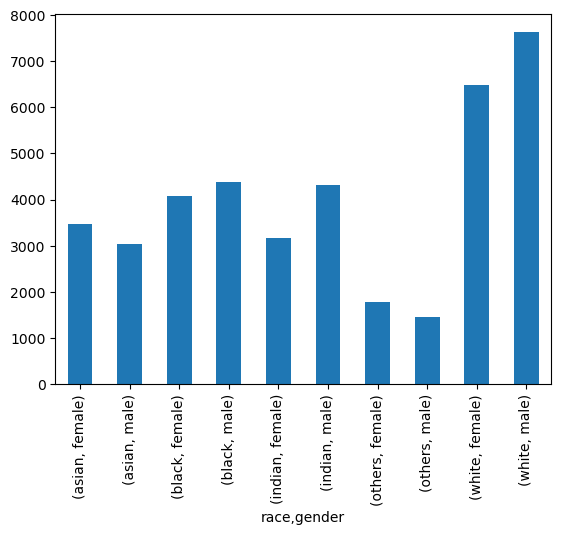

In [38]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

<Axes: >

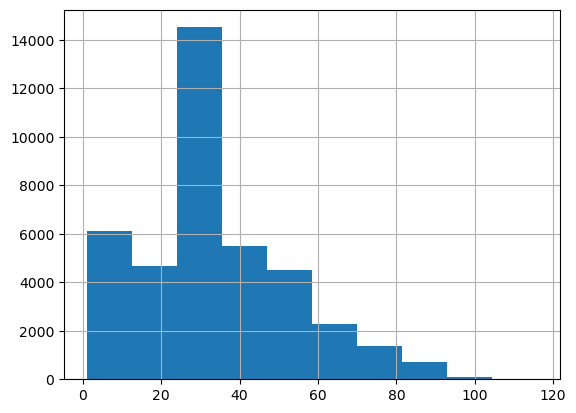

In [39]:
df['age'].hist()

In [40]:
df['age'].describe()
df = df[(df['age'] > 10) & (df['age'] < 70)]

In [41]:
# Calculate the number of samples to be added for the 'others' race
majority_count = df['race'].value_counts().max()  # This will give you the count of the race with the highest number of samples
others_count = df[df['race'] == 'others'].shape[0]
samples_to_add = majority_count - others_count

# Randomly sample samples_to_add number of rows from the 'others' race
oversampled_others_df = df[df['race'] == 'others'].sample(samples_to_add, replace=True, random_state=42)

# Add these to the original DataFrame
df = pd.concat([df, oversampled_others_df])

# Shuffle the DataFrame rows
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

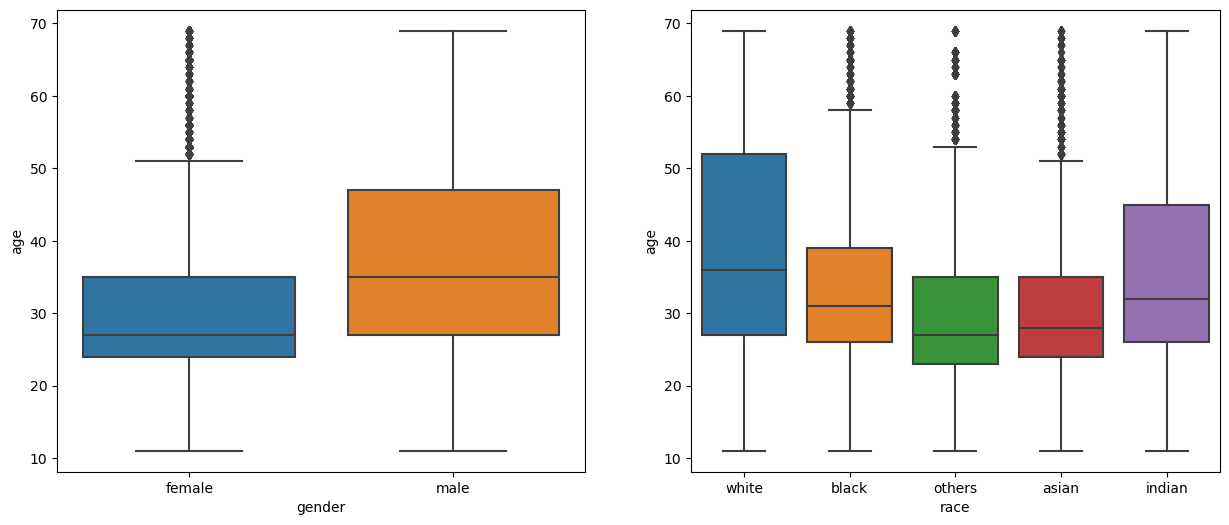

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
_ = sns.boxplot(data=df, x='gender', y='age', ax=ax1)
_ = sns.boxplot(data=df, x='race', y='age', ax=ax2)

<Axes: xlabel='gender', ylabel='age'>

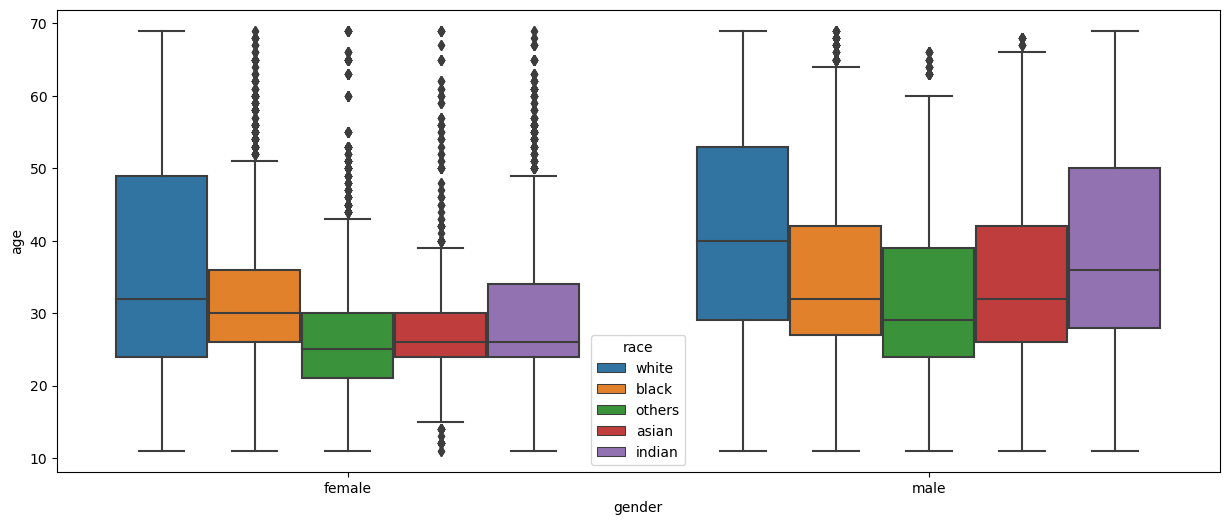

In [43]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df, x='gender', y='age', hue='race')

<Axes: xlabel='race,gender'>

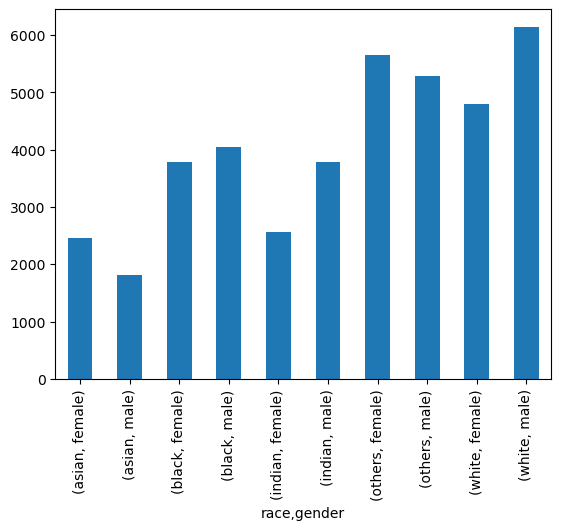

In [44]:
df.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

In [45]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
len(train_idx), len(valid_idx), len(test_idx), max_age

(19763, 8471, 12101, 69.0)

In [46]:
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 3]
        image = Image.open(img_name)
        age = self.df.iloc[idx, 0] / max_age
        race = torch.zeros(len(RACE_ID_MAP))
        race[self.df.iloc[idx, 5]] = 1
        gender = torch.zeros(2)
        gender[self.df.iloc[idx, 4]] = 1

        if self.transform:
            image = self.transform(image)

        return image, age, race, gender

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

dataset = UTKFaceDataset(df, transform)

train_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(valid_idx))
test_loader = DataLoader(dataset, batch_size=128, sampler=SubsetRandomSampler(test_idx))

In [47]:
class MobileNetV3Model(nn.Module):
    def __init__(self):
        super(MobileNetV3Model, self).__init__()
        
        # MobileNet V3 backbone
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Extra CNN layers for age
        self.age_cnn = nn.Sequential(
            self.conv_block(576, 192),
            self.conv_block(192, 128),
            self.conv_block(128, 64),
#             nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_age = nn.Sequential(
            nn.Linear(64, 128), 
            nn.ReLU(), 
            nn.Linear(128, 1)
        )

        # Extra CNN layers for race (ethnicity)
        self.race_cnn = nn.Sequential(
            self.conv_block(576, 192),
#             nn.MaxPool2d(2),
            self.conv_block(192, 128),
#             nn.MaxPool2d(2),
            self.conv_block(128, 64),
#             nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_race = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(128, len(RACE_ID_MAP))
        )

        # Extra CNN layers for gender
        self.gender_cnn = nn.Sequential(
            self.conv_block(576, 192),
            self.conv_block(192, 128),
            self.conv_block(128, 64),
#             nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_gender = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.43),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.43),
            nn.Linear(64, 2)
        )

    def conv_block(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1,1))
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.backbone(x)
# #         print("Shape after backbone:", x.shape)
#         age_x = self.age_cnn[0](x)
#         print("Shape after first conv_block in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[1](age_x)
#         print("Shape after second conv_block in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[2](age_x)
#         print("Shape after third conv_block in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[3](age_x)
#         print("Shape after MaxPool2d in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[4](age_x)
#         print("Shape after BatchNorm2d in age_cnn:", age_x.shape)

#         age_x = self.age_cnn[5](age_x)
#         print("Shape after ReLU in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[6](age_x)
#         print("Shape after AdaptiveAvgPool2d in age_cnn:", age_x.shape)
        age_x = self.age_cnn(x)
        age_x = torch.flatten(age_x, 1)
        age = torch.sigmoid(self.fc1_age(age_x))
        
        race_x = self.race_cnn(x)
        race_x = torch.flatten(race_x, 1)
        race = F.softmax(self.fc1_race(race_x), dim=1)
        
        gender_x = self.gender_cnn(x)
        gender_x = torch.flatten(gender_x, 1)
        gender = torch.sigmoid(self.fc1_gender(gender_x))#,dim=1)
        
        return age, race, gender

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  MobileNetV3Model().to(device)
model = model.float()
criterion_age = nn.MSELoss()
criterion_race = nn.CrossEntropyLoss()      #loss together backward or individually backward
criterion_gender = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(),lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)
# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [48]:
import time
import matplotlib.pyplot as plt

# Initialization
num_epochs = 100

# Lists to hold running losses for plotting
train_loss_age = []
train_loss_race = []
train_loss_gender = []
train_total_loss = []

# Lists to hold validation losses
valid_loss_age = []
valid_loss_race = []
valid_loss_gender = []
valid_total_loss = []

# Start the timer
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss_age = 0
    epoch_train_loss_race = 0
    epoch_train_loss_gender = 0
    epoch_train_total_loss = 0
    total_samples = 0
    
    for images, ages, races, genders in train_loader:
        images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
        
        optimizer.zero_grad()
        age_preds, race_preds, gender_preds = model(images)
        age_preds = age_preds.squeeze(1)
        
        loss_age = criterion_age(age_preds, ages)
        loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
        loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
        loss = 2*loss_age + 1.5*loss_race + loss_gender  
        
        loss.backward()
        optimizer.step()
        
        # Update the running losses
        epoch_train_loss_age += loss_age.item() * len(images)
        epoch_train_loss_race += loss_race.item() * len(images)
        epoch_train_loss_gender += loss_gender.item() * len(images)
        epoch_train_total_loss += loss.item() * len(images)
        total_samples += len(images)
    
    # Compute validation loss
    model.eval()
    epoch_valid_loss_age = 0
    epoch_valid_loss_race = 0
    epoch_valid_loss_gender = 0
    epoch_valid_total_loss = 0
    valid_samples = 0
    
    with torch.no_grad():
        for images, ages, races, genders in valid_loader:
            images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
            
            age_preds, race_preds, gender_preds = model(images)
            age_preds = age_preds.squeeze(1)
            
            loss_age = criterion_age(age_preds, ages)
            loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
            loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
            loss = 2*loss_age + 1.5*loss_race + loss_gender 
            
            epoch_valid_loss_age += loss_age.item() * len(images)
            epoch_valid_loss_race += loss_race.item() * len(images)
            epoch_valid_loss_gender += loss_gender.item() * len(images)
            epoch_valid_total_loss += loss.item() * len(images)
            valid_samples += len(images)
    
    # Average the losses over the epoch for training
    avg_train_loss_age = epoch_train_loss_age / total_samples
    avg_train_loss_race = epoch_train_loss_race / total_samples
    avg_train_loss_gender = epoch_train_loss_gender / total_samples
    avg_train_total_loss = epoch_train_total_loss / total_samples
    
    # Average the losses over the epoch for validation
    avg_valid_loss_age = epoch_valid_loss_age / valid_samples
    avg_valid_loss_race = epoch_valid_loss_race / valid_samples
    avg_valid_loss_gender = epoch_valid_loss_gender / valid_samples
    avg_valid_total_loss = epoch_valid_total_loss / valid_samples
    
    # Append the average losses for plotting later (training)
    train_loss_age.append(avg_train_loss_age)
    train_loss_race.append(avg_train_loss_race)
    train_loss_gender.append(avg_train_loss_gender)
    train_total_loss.append(avg_train_total_loss)
    
    # Append the average losses for plotting later (validation)
    valid_loss_age.append(avg_valid_loss_age)
    valid_loss_race.append(avg_valid_loss_race)
    valid_loss_gender.append(avg_valid_loss_gender)
    valid_total_loss.append(avg_valid_total_loss)

    # Print out the losses for training and validation
    print(f"Epoch [{epoch+1}/{num_epochs}] => Train Age Loss: {avg_train_loss_age:.9f}, Train Race Loss: {avg_train_loss_race:.9f}, Train Gender Loss: {avg_train_loss_gender:.9f}, Train Total Loss: {avg_train_total_loss:.9f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] => Valid Age Loss: {avg_valid_loss_age:.9f}, Valid Race Loss: {avg_valid_loss_race:.9f}, Valid Gender Loss: {avg_valid_loss_gender:.9f}, Valid Total Loss: {avg_valid_total_loss:.9f}")

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds")

Epoch [1/100] => Train Age Loss: 0.018467635, Train Race Loss: 1.450633534, Train Gender Loss: 0.533874430, Train Total Loss: 2.746760004
Epoch [1/100] => Valid Age Loss: 0.018824336, Valid Race Loss: 1.399761035, Valid Gender Loss: 0.419030975, Valid Total Loss: 2.556321202
Epoch [2/100] => Train Age Loss: 0.011795925, Train Race Loss: 1.215800962, Train Gender Loss: 0.374728213, Train Total Loss: 2.222021502
Epoch [2/100] => Valid Age Loss: 0.015034083, Valid Race Loss: 1.207501936, Valid Gender Loss: 0.372931690, Valid Total Loss: 2.214252764
Epoch [3/100] => Train Age Loss: 0.009402223, Train Race Loss: 1.125086415, Train Gender Loss: 0.357853877, Train Total Loss: 2.064287940
Epoch [3/100] => Valid Age Loss: 0.010879210, Valid Race Loss: 1.127279421, Valid Gender Loss: 0.361943065, Valid Total Loss: 2.074620611
Epoch [4/100] => Train Age Loss: 0.007934135, Train Race Loss: 1.061268556, Train Gender Loss: 0.352900347, Train Total Loss: 1.960671448
Epoch [4/100] => Valid Age Loss: 0

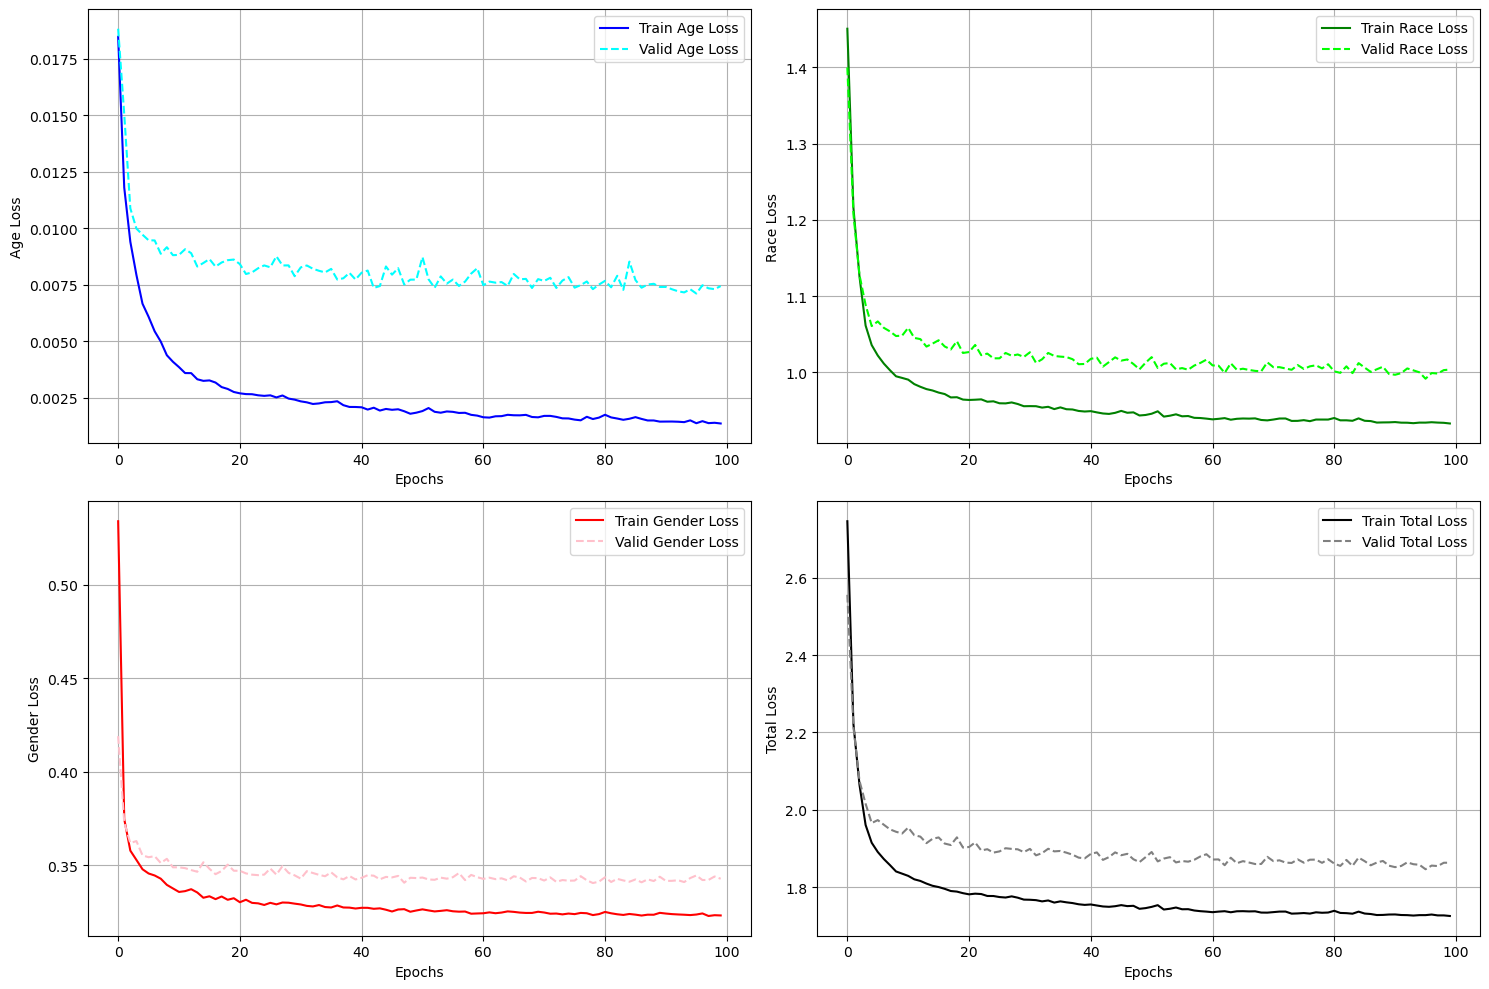

In [49]:
# Plotting the loss curves

plt.figure(figsize=(15, 10))

# Age Loss curve
plt.subplot(2, 2, 1)
plt.plot(train_loss_age, label='Train Age Loss', color='blue')
plt.plot(valid_loss_age, label='Valid Age Loss', color='cyan', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Age Loss')
plt.legend()
plt.grid(True)

# Race Loss curve
plt.subplot(2, 2, 2)
plt.plot(train_loss_race, label='Train Race Loss', color='green')
plt.plot(valid_loss_race, label='Valid Race Loss', color='lime', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Race Loss')
plt.legend()
plt.grid(True)

# Gender Loss curve
plt.subplot(2, 2, 3)
plt.plot(train_loss_gender, label='Train Gender Loss', color='red')
plt.plot(valid_loss_gender, label='Valid Gender Loss', color='pink', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Gender Loss')
plt.legend()
plt.grid(True)

# Total Loss curve
plt.subplot(2, 2, 4)
plt.plot(train_total_loss, label='Train Total Loss', color='black')
plt.plot(valid_total_loss, label='Valid Total Loss', color='gray', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [76]:
from sklearn.metrics import classification_report,mean_absolute_error, mean_squared_error

# Lists to store true labels and predictions
true_ages, pred_ages = [], []
true_races, pred_races = [], []
true_genders, pred_genders = [], []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, ages, races, genders in valid_loader:  # Assuming you have a validation loader called 'val_loader'
        images = images.float().to(device)

        # Get predictions
        age_preds, race_preds, gender_preds = model(images)

        # Convert predictions to class labels
        _, predicted_races = torch.max(race_preds, 1)
        _, predicted_genders = torch.max(gender_preds, 1)

        # Append true labels and predicted labels
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(age_preds.squeeze(1).cpu().numpy())

        true_races.extend(torch.argmax(races, dim=1).cpu().numpy())
        pred_races.extend(predicted_races.cpu().numpy())

        true_genders.extend(torch.argmax(genders, dim=1).cpu().numpy())
        pred_genders.extend(predicted_genders.cpu().numpy())

# Generate classification reports
print("Classification report for Age:")
# For regression task like Age, you might want to compute other metrics like MAE or MSE instead of classification report
# For demonstration, I'm just printing the first 10 true and predicted ages
print("True Ages:", true_ages[:10])
print("Predicted Ages:", pred_ages[:10])

# print("\nClassification report for Ages:")
# print(classification_report(true_ages, pred_ages))

# Report for Age:
print("Report for Age:")
mae = mean_absolute_error(true_ages, pred_ages)
mse = mean_squared_error(true_ages, pred_ages)
print(f"Mean Absolute Error for Age: {mae:.4f}")
print(f"Mean Squared Error for Age: {mse:.4f}")

print("\nClassification report for Race:")
print(classification_report(true_races, pred_races))

print("\nClassification report for Gender:")
print(classification_report(true_genders, pred_genders))

Classification report for Age:
True Ages: [0.5652173913043478, 0.5217391304347826, 0.2028985507246377, 0.4782608695652174, 0.6521739130434783, 0.4927536231884058, 0.43478260869565216, 0.9710144927536232, 0.782608695652174, 0.782608695652174]
Predicted Ages: [0.49795532, 0.5061153, 0.21781911, 0.51947284, 0.6419908, 0.5035187, 0.4667401, 0.4969589, 0.8143331, 0.7171361]
Report for Age:
Mean Absolute Error for Age: 0.0663
Mean Squared Error for Age: 0.0098

Classification report for Race:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      2333
           1       0.88      0.95      0.92      1641
           2       0.93      0.89      0.91       893
           3       0.83      0.87      0.85      1293
           4       0.71      0.51      0.59       519

    accuracy                           0.87      6679
   macro avg       0.85      0.82      0.83      6679
weighted avg       0.87      0.87      0.87      6679


Classification rep

In [61]:
import time
import matplotlib.pyplot as plt

# Initialization
num_epochs = 100

# Lists to hold running losses for plotting
train_loss_age = []
train_loss_race = []
train_loss_gender = []
train_total_loss = []

# Lists to hold validation losses
valid_loss_age = []
valid_loss_race = []
valid_loss_gender = []
valid_total_loss = []

# Start the timer
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss_age = 0
    epoch_train_loss_race = 0
    epoch_train_loss_gender = 0
    epoch_train_total_loss = 0
    total_samples = 0
    
    for images, ages, races, genders in train_loader:
        images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
        
        optimizer.zero_grad()
        age_preds, race_preds, gender_preds = model(images)
        age_preds = age_preds.squeeze(1)
        
        loss_age = criterion_age(age_preds, ages)
        loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
        loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
        loss = 2*loss_age + 1.5*loss_race + loss_gender  
        
        loss.backward()
        optimizer.step()
        
        # Update the running losses
        epoch_train_loss_age += loss_age.item() * len(images)
        epoch_train_loss_race += loss_race.item() * len(images)
        epoch_train_loss_gender += loss_gender.item() * len(images)
        epoch_train_total_loss += loss.item() * len(images)
        total_samples += len(images)
    
    # Compute validation loss
    model.eval()
    epoch_valid_loss_age = 0
    epoch_valid_loss_race = 0
    epoch_valid_loss_gender = 0
    epoch_valid_total_loss = 0
    valid_samples = 0
    
    with torch.no_grad():
        for images, ages, races, genders in valid_loader:
            images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
            
            age_preds, race_preds, gender_preds = model(images)
            age_preds = age_preds.squeeze(1)
            
            loss_age = criterion_age(age_preds, ages)
            loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
            loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
            loss = 2*loss_age + 1.5*loss_race + loss_gender 
            
            epoch_valid_loss_age += loss_age.item() * len(images)
            epoch_valid_loss_race += loss_race.item() * len(images)
            epoch_valid_loss_gender += loss_gender.item() * len(images)
            epoch_valid_total_loss += loss.item() * len(images)
            valid_samples += len(images)
    
    # Average the losses over the epoch for training
    avg_train_loss_age = epoch_train_loss_age / total_samples
    avg_train_loss_race = epoch_train_loss_race / total_samples
    avg_train_loss_gender = epoch_train_loss_gender / total_samples
    avg_train_total_loss = epoch_train_total_loss / total_samples
    
    # Average the losses over the epoch for validation
    avg_valid_loss_age = epoch_valid_loss_age / valid_samples
    avg_valid_loss_race = epoch_valid_loss_race / valid_samples
    avg_valid_loss_gender = epoch_valid_loss_gender / valid_samples
    avg_valid_total_loss = epoch_valid_total_loss / valid_samples
    
    # Append the average losses for plotting later (training)
    train_loss_age.append(avg_train_loss_age)
    train_loss_race.append(avg_train_loss_race)
    train_loss_gender.append(avg_train_loss_gender)
    train_total_loss.append(avg_train_total_loss)
    
    # Append the average losses for plotting later (validation)
    valid_loss_age.append(avg_valid_loss_age)
    valid_loss_race.append(avg_valid_loss_race)
    valid_loss_gender.append(avg_valid_loss_gender)
    valid_total_loss.append(avg_valid_total_loss)

    # Print out the losses for training and validation
    print(f"Epoch [{epoch+1}/{num_epochs}] => Train Age Loss: {avg_train_loss_age:.9f}, Train Race Loss: {avg_train_loss_race:.9f}, Train Gender Loss: {avg_train_loss_gender:.9f}, Train Total Loss: {avg_train_total_loss:.9f}")
    print(f"Epoch [{epoch+1}/{num_epochs}] => Valid Age Loss: {avg_valid_loss_age:.9f}, Valid Race Loss: {avg_valid_loss_race:.9f}, Valid Gender Loss: {avg_valid_loss_gender:.9f}, Valid Total Loss: {avg_valid_total_loss:.9f}")

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds")

Epoch [1/100] => Train Age Loss: 0.020665035, Train Race Loss: 1.444625846, Train Gender Loss: 0.574362185, Train Total Loss: 2.782631038
Epoch [1/100] => Valid Age Loss: 0.031003460, Valid Race Loss: 1.469084951, Valid Gender Loss: 0.484065586, Valid Total Loss: 2.749699952
Epoch [2/100] => Train Age Loss: 0.013388227, Train Race Loss: 1.182431803, Train Gender Loss: 0.389473003, Train Total Loss: 2.189897167
Epoch [2/100] => Valid Age Loss: 0.015974672, Valid Race Loss: 1.184446131, Valid Gender Loss: 0.375400530, Valid Total Loss: 2.184019075
Epoch [3/100] => Train Age Loss: 0.011144631, Train Race Loss: 1.099206944, Train Gender Loss: 0.361893589, Train Total Loss: 2.032993271
Epoch [3/100] => Valid Age Loss: 0.012861642, Valid Race Loss: 1.103639543, Valid Gender Loss: 0.363605317, Valid Total Loss: 2.044787925
Epoch [4/100] => Train Age Loss: 0.009449432, Train Race Loss: 1.073753703, Train Gender Loss: 0.354852504, Train Total Loss: 1.984381927
Epoch [4/100] => Valid Age Loss: 0

In [62]:
# import time
# # Initialization
# num_epochs = 100

# # Lists to hold running losses for plotting
# running_loss_age = []
# running_loss_race = []
# running_loss_gender = []
# running_total_loss = []

# # Start the timer
# start_time = time.time()

# for epoch in range(num_epochs):
#     model.train()
#     epoch_loss_age = 0
#     epoch_loss_race = 0
#     epoch_loss_gender = 0
#     epoch_total_loss = 0
#     total_samples = 0
    
#     for images, ages, races, genders in train_loader:
# #         print(images.shape)
#         images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
        
#         optimizer.zero_grad()
#         age_preds, race_preds, gender_preds = model(images)
# #         print(age_preds.shape)
# #         print(race_preds.shape)
# #         print(gender_preds.shape)
#         age_preds = age_preds.squeeze(1)
#         loss_age = criterion_age(age_preds, ages)
#         loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
#         loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
#         loss = 2*loss_age + 1.5*loss_race + loss_gender  #Why are these values being multiplied?
#         loss = loss.float()
#         #print(loss)
#         loss.backward()
#         optimizer.step()
        
#         # Update the running losses
#         epoch_loss_age += loss_age.item() * len(images)
#         epoch_loss_race += loss_race.item() * len(images)
#         epoch_loss_gender += loss_gender.item() * len(images)
#         epoch_total_loss += loss.item() * len(images)
#         total_samples += len(images)
        
#     # Average the losses over the epoch
#     avg_loss_age = epoch_loss_age / total_samples
#     avg_loss_race = epoch_loss_race / total_samples
#     avg_loss_gender = epoch_loss_gender / total_samples
#     avg_total_loss = epoch_total_loss / total_samples

#     # Append the average losses for plotting later
#     running_loss_age.append(avg_loss_age)
#     running_loss_race.append(avg_loss_race)
#     running_loss_gender.append(avg_loss_gender)
#     running_total_loss.append(avg_total_loss)

#     # Print out the losses

#     print(f"Epoch [{epoch+1}/{num_epochs}] => Age Loss: {avg_loss_age:.9f}, Race Loss: {avg_loss_race:.9f}, Gender Loss: {avg_loss_gender:.9f}, Total Loss: {avg_total_loss:.9f}")

# # End the timer
# end_time = time.time()
# elapsed_time = end_time - start_time
# print(f"Training took {elapsed_time:.2f} seconds")
# #Save the trained model's parameters

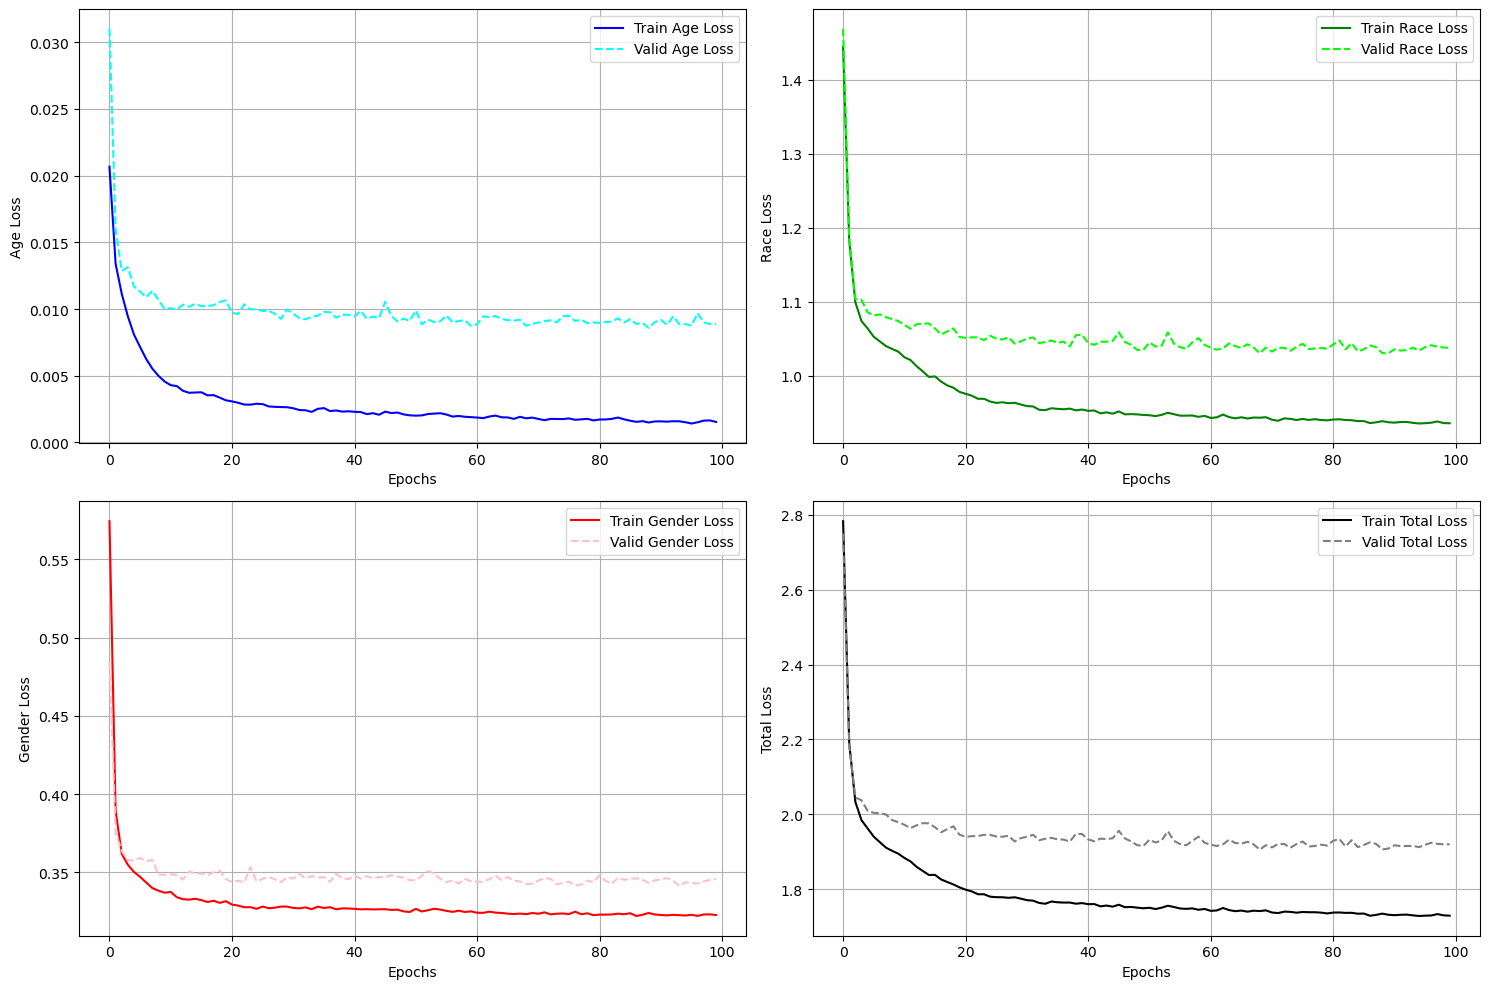

In [63]:
# Plotting the loss curves

plt.figure(figsize=(15, 10))

# Age Loss curve
plt.subplot(2, 2, 1)
plt.plot(train_loss_age, label='Train Age Loss', color='blue')
plt.plot(valid_loss_age, label='Valid Age Loss', color='cyan', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Age Loss')
plt.legend()
plt.grid(True)

# Race Loss curve
plt.subplot(2, 2, 2)
plt.plot(train_loss_race, label='Train Race Loss', color='green')
plt.plot(valid_loss_race, label='Valid Race Loss', color='lime', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Race Loss')
plt.legend()
plt.grid(True)

# Gender Loss curve
plt.subplot(2, 2, 3)
plt.plot(train_loss_gender, label='Train Gender Loss', color='red')
plt.plot(valid_loss_gender, label='Valid Gender Loss', color='pink', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Gender Loss')
plt.legend()
plt.grid(True)

# Total Loss curve
plt.subplot(2, 2, 4)
plt.plot(train_total_loss, label='Train Total Loss', color='black')
plt.plot(valid_total_loss, label='Valid Total Loss', color='gray', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Total Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

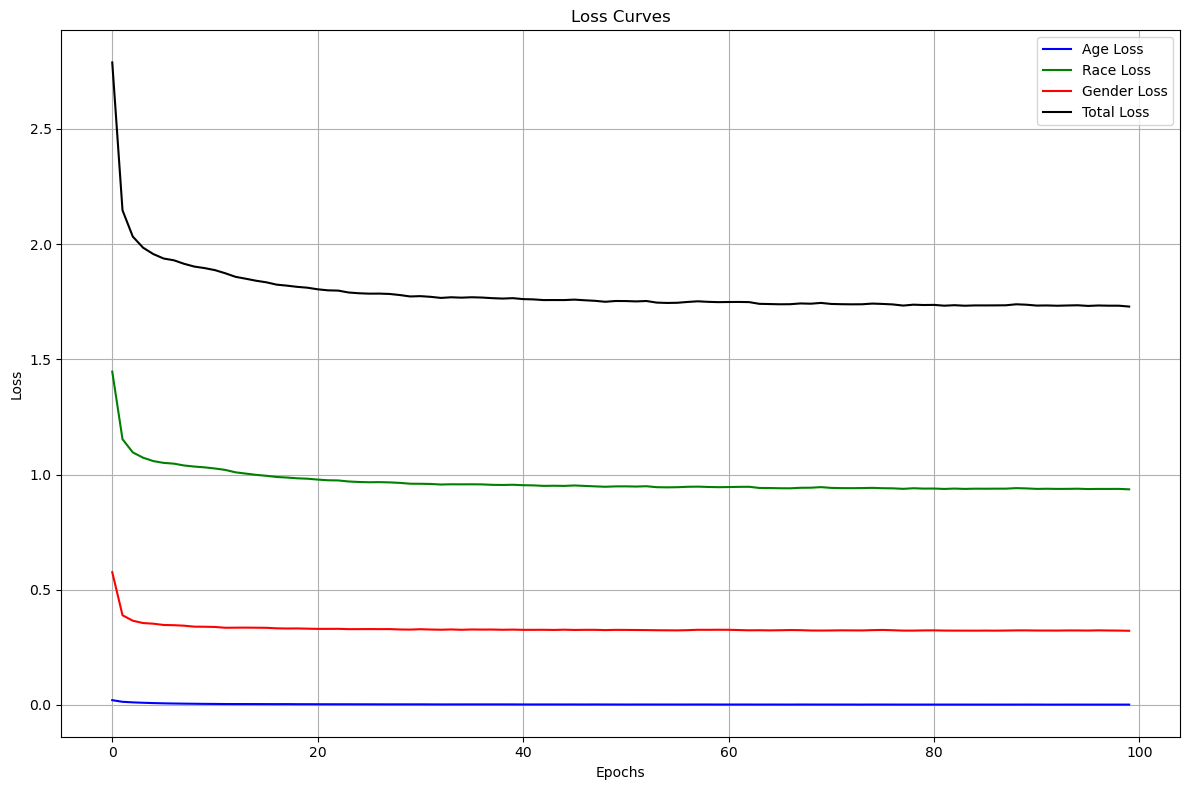

In [21]:
# # Plotting the loss curves

# plt.figure(figsize=(12, 8))

# # Age Loss curve
# plt.plot(running_loss_age, label='Age Loss', color='blue')
# # Race Loss curve
# plt.plot(running_loss_race, label='Race Loss', color='green')
# # Gender Loss curve
# plt.plot(running_loss_gender, label='Gender Loss', color='red')
# # Total Loss curve
# plt.plot(running_total_loss, label='Total Loss', color='black')

# # Setting x and y axis labels
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss Curves')

# # Displaying the legend
# plt.legend()

# # Show the plot
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [22]:
model_directory = "/kaggle/working/Multitask_MobileNet_v3/"
os.makedirs(model_directory, exist_ok = True)

model_path = model_directory+"model_weights.pt"
torch.save(model, model_path)

In [64]:
from sklearn.metrics import classification_report,mean_absolute_error, mean_squared_error

# Lists to store true labels and predictions
true_ages, pred_ages = [], []
true_races, pred_races = [], []
true_genders, pred_genders = [], []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, ages, races, genders in valid_loader:  # Assuming you have a validation loader called 'val_loader'
        images = images.float().to(device)

        # Get predictions
        age_preds, race_preds, gender_preds = model(images)

        # Convert predictions to class labels
        _, predicted_races = torch.max(race_preds, 1)
        _, predicted_genders = torch.max(gender_preds, 1)

        # Append true labels and predicted labels
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(age_preds.squeeze(1).cpu().numpy())

        true_races.extend(torch.argmax(races, dim=1).cpu().numpy())
        pred_races.extend(predicted_races.cpu().numpy())

        true_genders.extend(torch.argmax(genders, dim=1).cpu().numpy())
        pred_genders.extend(predicted_genders.cpu().numpy())

# Generate classification reports
print("Classification report for Age:")
print("True Ages:", true_ages[:10])
print("Predicted Ages:", pred_ages[:10])

# print("\nClassification report for Ages:")
# print(classification_report(true_ages, pred_ages))

# Report for Age:
print("Report for Age:")
mae = mean_absolute_error(true_ages, pred_ages)
mse = mean_squared_error(true_ages, pred_ages)
print(f"Mean Absolute Error for Age: {mae:.4f}")
print(f"Mean Squared Error for Age: {mse:.4f}")

print("\nClassification report for Race:")
print(classification_report(true_races, pred_races))

print("\nClassification report for Gender:")
print(classification_report(true_genders, pred_genders))

Classification report for Age:
True Ages: [0.37681159420289856, 0.391304347826087, 0.30434782608695654, 0.3333333333333333, 0.43478260869565216, 0.391304347826087, 0.463768115942029, 0.855072463768116, 0.6086956521739131, 0.8840579710144928]
Predicted Ages: [0.27080318, 0.287292, 0.32220358, 0.3632853, 0.44180146, 0.44076586, 0.453725, 0.85529697, 0.61975086, 0.86398405]
Report for Age:
Mean Absolute Error for Age: 0.0643
Mean Squared Error for Age: 0.0089

Classification report for Race:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2268
           1       0.91      0.93      0.92      1658
           2       0.87      0.89      0.88       919
           3       0.84      0.89      0.87      1339
           4       0.60      0.52      0.55       495

    accuracy                           0.87      6679
   macro avg       0.82      0.82      0.82      6679
weighted avg       0.86      0.87      0.87      6679


Classification r

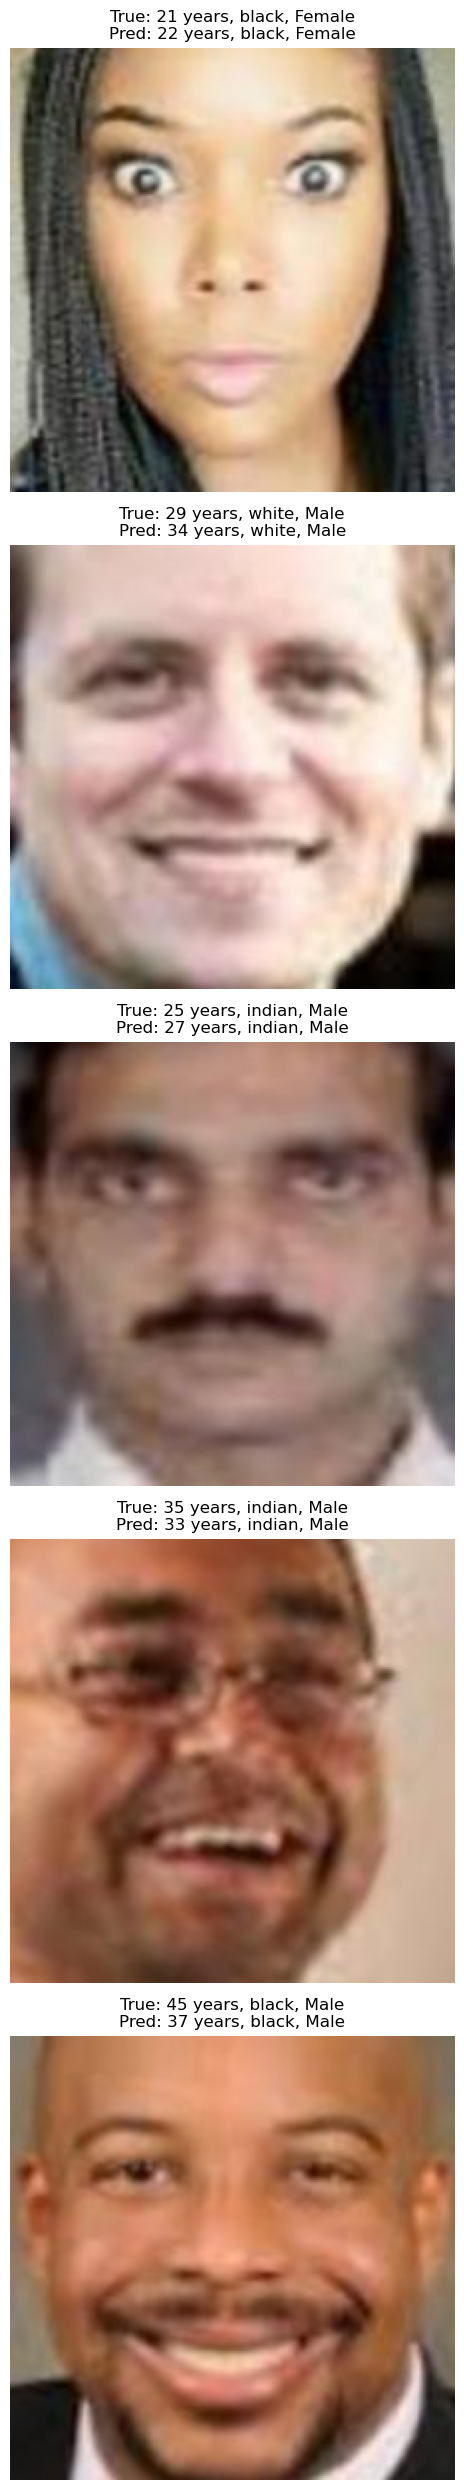

In [70]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    image_count = 0
    fig, axs = plt.subplots(num_images, figsize=(10, 5 * num_images))

    with torch.no_grad():
          for images, ages, races, genders in loader:
            if image_count >= num_images:
#         for idx, (images, ages, races, genders) in enumerate(loader):
#             if idx == num_images:
                break

            images = images.float().to(device)
            age_preds, race_preds, gender_preds = model(images)

            _, predicted_races = torch.max(race_preds, 1)
            _, predicted_genders = torch.max(gender_preds, 1)

            for i in range(images.size(0)):
                if image_count >= num_images:
                    break
            # Convert the predictions back to the label names
            pred_age = int(age_preds[i].squeeze().item() * max_age)
            true_age = int(ages[i].item() * max_age)

            # Assuming you have a reverse dictionary to map from label ID back to race name
#             pred_race = REVERSE_RACE_ID_MAP[predicted_races.item()]  
#             true_race = REVERSE_RACE_ID_MAP[torch.argmax(races, dim=1).item()]

            pred_race = ID_RACE_MAP[predicted_races[i].item()]
            true_race = ID_RACE_MAP[torch.argmax(races[i], dim=0).item()]


#             pred_gender = "Male" if predicted_genders.item() == 1 else "Female"
#             true_gender = "Male" if torch.argmax(genders, dim=1).item() == 1 else "Female"
            pred_gender = "Female" if predicted_genders[i].item() == 1 else "Male"
            true_gender = "Female" if torch.argmax(genders[i], dim=0).item() == 1 else "Male"
                
            # Plotting the image with predictions and true labels
#             axs[idx].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
#             axs[idx].axis('off')
#             axs[idx].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
            axs[image_count].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
            axs[image_count].axis('off')
            axs[image_count].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
                
            image_count += 1

    plt.tight_layout()
    plt.show()

# Visualize the predictions on the validation dataset
visualize_predictions(model, valid_loader)

In [ ]:
class UTKFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 3]
        image = Image.open(img_name)
        age = self.df.iloc[idx, 0] / max_age
        race = torch.zeros(len(RACE_ID_MAP))
        race[self.df.iloc[idx, 5]] = 1
        gender = torch.zeros(2)
        gender[self.df.iloc[idx, 4]] = 1

        if self.transform:
            image = self.transform(image)

        return image, age, race, gender

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = UTKFaceDataset(df, transform)

train_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(train_idx))
valid_loader = DataLoader(dataset, batch_size=64, sampler=SubsetRandomSampler(valid_idx))
test_loader = DataLoader(dataset, batch_size=128, sampler=SubsetRandomSampler(test_idx))

In [19]:
class MobileNetV3Model(nn.Module):
    def __init__(self):
        super(MobileNetV3Model, self).__init__()
        
        # MobileNet V3 backbone
        self.backbone = models.mobilenet_v3_small(pretrained=True)
        self.backbone = nn.Sequential(*list(self.backbone.children())[:-1])

        # Extra CNN layers for age
        self.age_cnn = nn.Sequential(
            self.conv_block(576, 192),
            self.conv_block(192, 128),
            self.conv_block(128, 64),
#             nn.MaxPool2d(2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_age = nn.Sequential(
            nn.Linear(64, 128), 
            nn.ReLU(), 
            nn.Linear(128, 1)
        )

        # Extra CNN layers for race (ethnicity)
        self.race_cnn = nn.Sequential(
            self.conv_block(576, 192),
#             nn.MaxPool2d(2),
            self.conv_block(192, 128),
#             nn.MaxPool2d(2),
            self.conv_block(128, 64),
#             nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_race = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.35),
            nn.Linear(128, len(RACE_ID_MAP))
        )

        # Extra CNN layers for gender
        self.gender_cnn = nn.Sequential(
            self.conv_block(576, 192),
            self.conv_block(192, 128),
            self.conv_block(128, 64),
#             nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc1_gender = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Dropout(0.43),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.43),
            nn.Linear(64, 2)
        )

    def conv_block(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
#             nn.AdaptiveAvgPool2d((1,1))
        ]
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.backbone(x)
# #         print("Shape after backbone:", x.shape)
#         age_x = self.age_cnn[0](x)
#         print("Shape after first conv_block in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[1](age_x)
#         print("Shape after second conv_block in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[2](age_x)
#         print("Shape after third conv_block in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[3](age_x)
#         print("Shape after MaxPool2d in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[4](age_x)
#         print("Shape after BatchNorm2d in age_cnn:", age_x.shape)

#         age_x = self.age_cnn[5](age_x)
#         print("Shape after ReLU in age_cnn:", age_x.shape)
    
#         age_x = self.age_cnn[6](age_x)
#         print("Shape after AdaptiveAvgPool2d in age_cnn:", age_x.shape)
        age_x = self.age_cnn(x)
        age_x = torch.flatten(age_x, 1)
        age = torch.sigmoid(self.fc1_age(age_x))
        
        race_x = self.race_cnn(x)
        race_x = torch.flatten(race_x, 1)
        race = F.softmax(self.fc1_race(race_x), dim=1)
        
        gender_x = self.gender_cnn(x)
        gender_x = torch.flatten(gender_x, 1)
        gender = torch.sigmoid(self.fc1_gender(gender_x))#,dim=1)
        
        return age, race, gender

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model =  MobileNetV3Model().to(device)
model = model.float()
criterion_age = nn.MSELoss()
criterion_race = nn.CrossEntropyLoss()      #loss together backward or individually backward
criterion_gender = nn.CrossEntropyLoss()
# optimizer = torch.optim.RMSprop(model.parameters(),lr=0.0001)
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 115MB/s]


In [20]:
import time
# Initialization
num_epochs = 100

# Lists to hold running losses for plotting
running_loss_age = []
running_loss_race = []
running_loss_gender = []
running_total_loss = []

# Start the timer
start_time = time.time()

for epoch in range(num_epochs):
    model.train()
    epoch_loss_age = 0
    epoch_loss_race = 0
    epoch_loss_gender = 0
    epoch_total_loss = 0
    total_samples = 0
    
    for images, ages, races, genders in train_loader:
#         print(images.shape)
        images, ages, races, genders = images.float().to(device), ages.float().to(device), races.float().to(device), genders.float().to(device)
        
        optimizer.zero_grad()
        age_preds, race_preds, gender_preds = model(images)
#         print(age_preds.shape)
#         print(race_preds.shape)
#         print(gender_preds.shape)
        age_preds = age_preds.squeeze(1)
        loss_age = criterion_age(age_preds, ages)
        loss_race = criterion_race(race_preds, torch.argmax(races, dim=1))
        loss_gender = criterion_gender(gender_preds, torch.argmax(genders, dim=1))
        loss = 2*loss_age + 1.5*loss_race + loss_gender  #Why are these values being multiplied?
        loss = loss.float()
        #print(loss)
        loss.backward()
        optimizer.step()
        
        # Update the running losses
        epoch_loss_age += loss_age.item() * len(images)
        epoch_loss_race += loss_race.item() * len(images)
        epoch_loss_gender += loss_gender.item() * len(images)
        epoch_total_loss += loss.item() * len(images)
        total_samples += len(images)
        
    # Average the losses over the epoch
    avg_loss_age = epoch_loss_age / total_samples
    avg_loss_race = epoch_loss_race / total_samples
    avg_loss_gender = epoch_loss_gender / total_samples
    avg_total_loss = epoch_total_loss / total_samples

    # Append the average losses for plotting later
    running_loss_age.append(avg_loss_age)
    running_loss_race.append(avg_loss_race)
    running_loss_gender.append(avg_loss_gender)
    running_total_loss.append(avg_total_loss)

    # Print out the losses

    print(f"Epoch [{epoch+1}/{num_epochs}] => Age Loss: {avg_loss_age:.9f}, Race Loss: {avg_loss_race:.9f}, Gender Loss: {avg_loss_gender:.9f}, Total Loss: {avg_total_loss:.9f}")

# End the timer
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training took {elapsed_time:.2f} seconds")
    
#Save the trained model's parameters

Epoch [1/100] => Age Loss: 0.023768769, Race Loss: 1.446210684, Gender Loss: 0.593552748, Total Loss: 2.810406303
Epoch [2/100] => Age Loss: 0.017963875, Race Loss: 1.301878671, Gender Loss: 0.420938564, Total Loss: 2.409684327
Epoch [3/100] => Age Loss: 0.016699840, Race Loss: 1.211974235, Gender Loss: 0.396503254, Total Loss: 2.247864301
Epoch [4/100] => Age Loss: 0.015353474, Race Loss: 1.168562489, Gender Loss: 0.387500789, Total Loss: 2.171051471
Epoch [5/100] => Age Loss: 0.014608488, Race Loss: 1.148667676, Gender Loss: 0.380601690, Total Loss: 2.132820176
Epoch [6/100] => Age Loss: 0.013938750, Race Loss: 1.140285169, Gender Loss: 0.378877869, Total Loss: 2.117183127
Epoch [7/100] => Age Loss: 0.013287527, Race Loss: 1.132393167, Gender Loss: 0.374631690, Total Loss: 2.099796490
Epoch [8/100] => Age Loss: 0.013029455, Race Loss: 1.125697756, Gender Loss: 0.372375273, Total Loss: 2.086980814
Epoch [9/100] => Age Loss: 0.012469916, Race Loss: 1.117142551, Gender Loss: 0.369627078

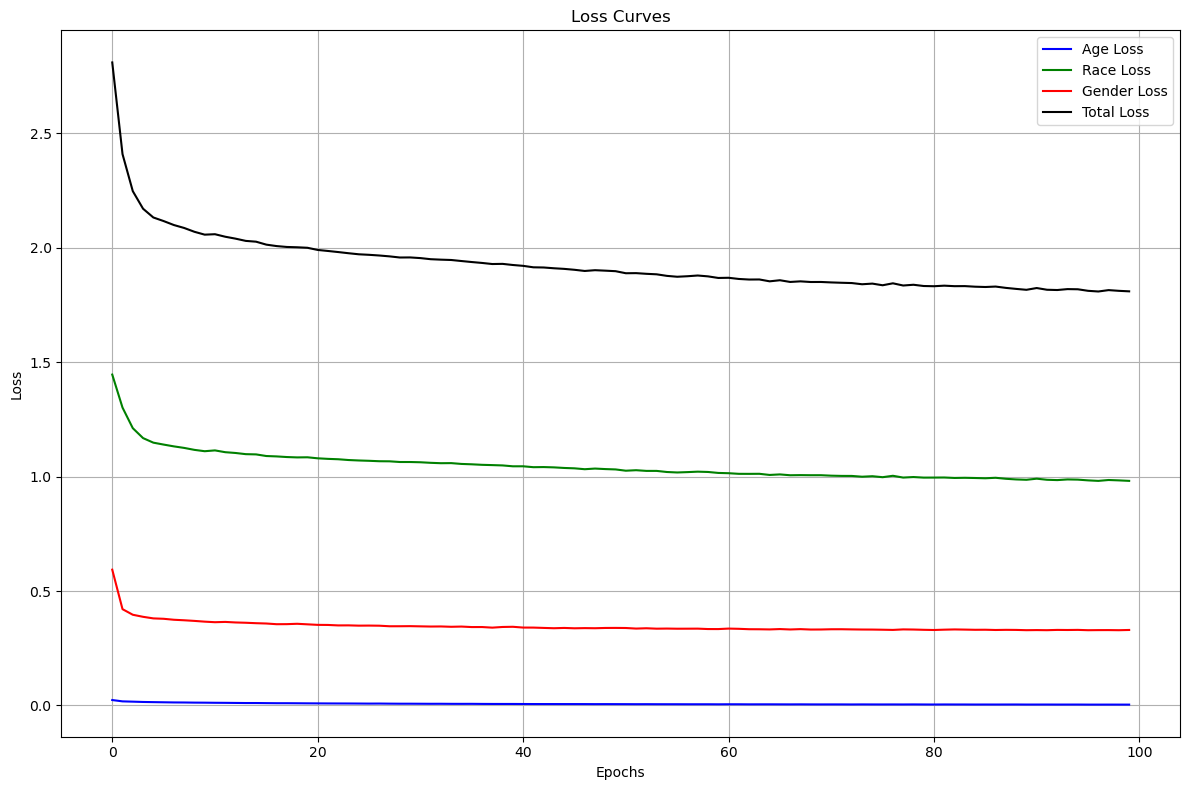

In [26]:
# Plotting the loss curves

plt.figure(figsize=(12, 8))

# Age Loss curve
plt.plot(running_loss_age, label='Age Loss', color='blue')
# Race Loss curve
plt.plot(running_loss_race, label='Race Loss', color='green')
# Gender Loss curve
plt.plot(running_loss_gender, label='Gender Loss', color='red')
# Total Loss curve
plt.plot(running_total_loss, label='Total Loss', color='black')

# Setting x and y axis labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')

# Displaying the legend
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
model_directory = "/kaggle/working/Multitask_MobileNet_v3_augmentations_applied/"
os.makedirs(model_directory, exist_ok = True)

model_path = model_directory+"model_weights.pt"
torch.save(model, model_path)

In [30]:
from sklearn.metrics import classification_report, mean_absolute_error, mean_squared_error

# Lists to store true labels and predictions
true_ages, pred_ages = [], []
true_races, pred_races = [], []
true_genders, pred_genders = [], []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for images, ages, races, genders in valid_loader:  # Assuming you have a validation loader called 'val_loader'
        images = images.float().to(device)

        # Get predictions
        age_preds, race_preds, gender_preds = model(images)

        # Convert predictions to class labels
        _, predicted_races = torch.max(race_preds, 1)
        _, predicted_genders = torch.max(gender_preds, 1)

        # Append true labels and predicted labels
        true_ages.extend(ages.cpu().numpy())
        pred_ages.extend(age_preds.squeeze(1).cpu().numpy())

        true_races.extend(torch.argmax(races, dim=1).cpu().numpy())
        pred_races.extend(predicted_races.cpu().numpy())

        true_genders.extend(torch.argmax(genders, dim=1).cpu().numpy())
        pred_genders.extend(predicted_genders.cpu().numpy())

# Generate classification reports
print("Classification report for Age:")
# For regression task like Age, you might want to compute other metrics like MAE or MSE instead of classification report
# For demonstration, I'm just printing the first 10 true and predicted ages
print("True Ages:", true_ages[:10])
print("Predicted Ages:", pred_ages[:10])

# print("\nClassification report for Age:")
# print(classification_report(true_ages, pred_ages))

# Report for Age:
print("Report for Age:")
mae = mean_absolute_error(true_ages, pred_ages)
mse = mean_squared_error(true_ages, pred_ages)
print(f"Mean Absolute Error for Age: {mae:.4f}")
print(f"Mean Squared Error for Age: {mse:.4f}")

print("\nClassification report for Race:")
print(classification_report(true_races, pred_races))

print("\nClassification report for Gender:")
print(classification_report(true_genders, pred_genders))

Classification report for Age:
True Ages: [0.3333333333333333, 0.5072463768115942, 0.2318840579710145, 0.7246376811594203, 0.782608695652174, 0.5072463768115942, 0.391304347826087, 0.6086956521739131, 0.30434782608695654, 0.4057971014492754]
Predicted Ages: [0.38901547, 0.31700835, 0.19243234, 0.7230309, 0.79904866, 0.3745778, 0.39347816, 0.6860549, 0.5492048, 0.3675592]
Report for Age:
Mean Absolute Error for Age: 0.0713
Mean Squared Error for Age: 0.0097

Classification report for Race:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      2308
           1       0.88      0.94      0.91      1592
           2       0.87      0.90      0.89       903
           3       0.87      0.77      0.82      1356
           4       0.59      0.43      0.49       520

    accuracy                           0.85      6679
   macro avg       0.81      0.79      0.79      6679
weighted avg       0.84      0.85      0.84      6679


Classification r

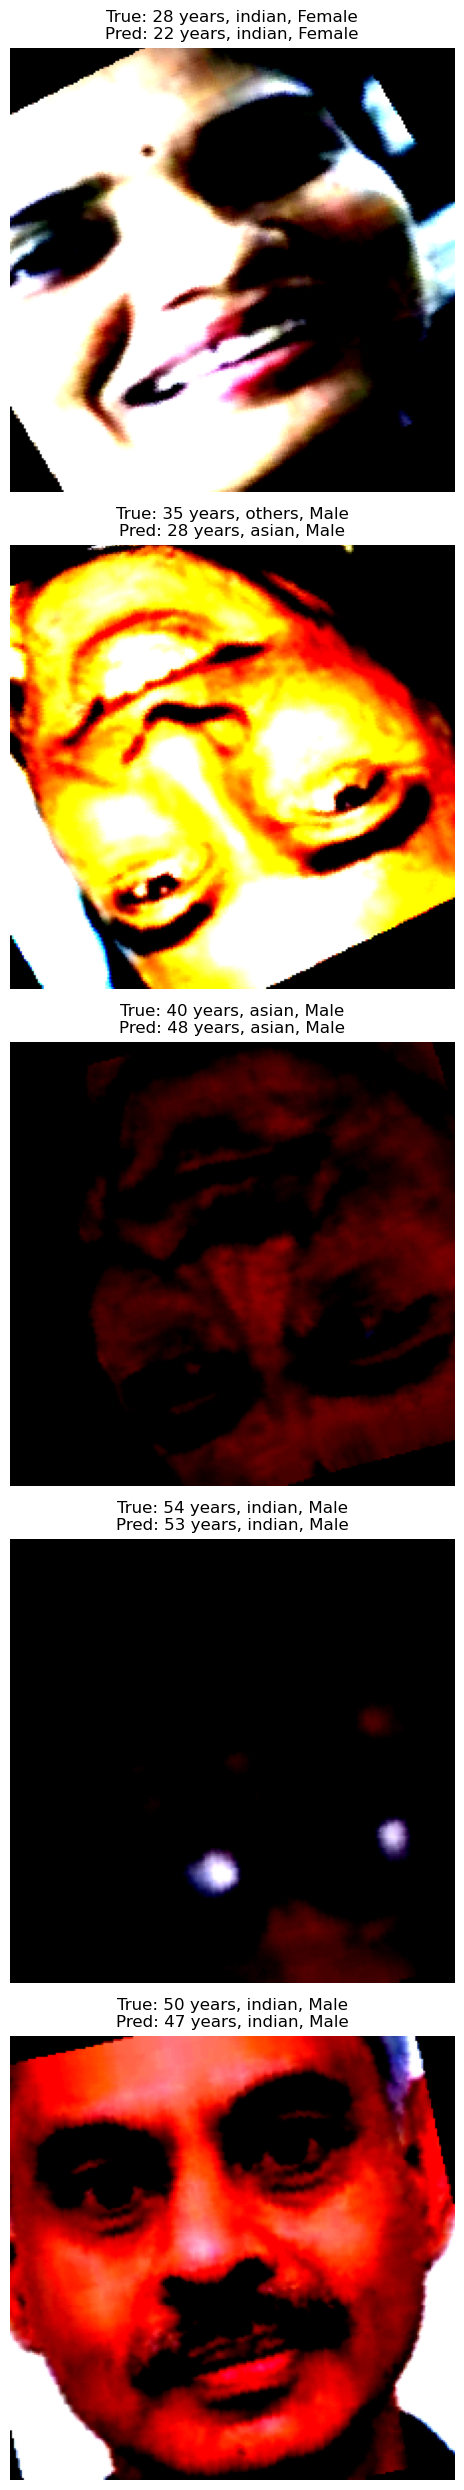

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_predictions(model, loader, num_images=5):
    model.eval()
    image_count = 0
    fig, axs = plt.subplots(num_images, figsize=(10, 5 * num_images))

    with torch.no_grad():
          for images, ages, races, genders in loader:
            if image_count >= num_images:
#         for idx, (images, ages, races, genders) in enumerate(loader):
#             if idx == num_images:
                break

            images = images.float().to(device)
            age_preds, race_preds, gender_preds = model(images)

            _, predicted_races = torch.max(race_preds, 1)
            _, predicted_genders = torch.max(gender_preds, 1)

            for i in range(images.size(0)):
                if image_count >= num_images:
                    break
            # Convert the predictions back to the label names
            pred_age = int(age_preds[i].squeeze().item() * max_age)
            true_age = int(ages[i].item() * max_age)

            # Assuming you have a reverse dictionary to map from label ID back to race name
#             pred_race = REVERSE_RACE_ID_MAP[predicted_races.item()]  
#             true_race = REVERSE_RACE_ID_MAP[torch.argmax(races, dim=1).item()]

            pred_race = ID_RACE_MAP[predicted_races[i].item()]
            true_race = ID_RACE_MAP[torch.argmax(races[i], dim=0).item()]


#             pred_gender = "Male" if predicted_genders.item() == 1 else "Female"
#             true_gender = "Male" if torch.argmax(genders, dim=1).item() == 1 else "Female"
            pred_gender = "Female" if predicted_genders[i].item() == 1 else "Male"
            true_gender = "Female" if torch.argmax(genders[i], dim=0).item() == 1 else "Male"
                
            # Plotting the image with predictions and true labels
#             axs[idx].imshow(np.transpose(images[0].cpu().numpy(), (1, 2, 0)))
#             axs[idx].axis('off')
#             axs[idx].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
            axs[image_count].imshow(np.transpose(images[i].cpu().numpy(), (1, 2, 0)))
            axs[image_count].axis('off')
            axs[image_count].set_title(f"True: {true_age} years, {true_race}, {true_gender}\nPred: {pred_age} years, {pred_race}, {pred_gender}")
                
            image_count += 1

    plt.tight_layout()
    plt.show()

# Visualize the predictions on the validation dataset
visualize_predictions(model, valid_loader)

In [ ]:
# import torch.nn as nn
# import torchvision.models as models

# class AgeGenderMobileNetV3(nn.Module):
#     def __init__(self, pretrained=True):
#         super(AgeGenderMobileNetV3, self).__init__()

#         # Load the pre-trained MobileNetV3 model
#         self.base_model = models.mobilenet_v3_small(pretrained=pretrained)  # You can also use mobilenet_v3_large
#         self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # Remove last classifier

#         # Add custom classifiers
#         self.age_head = nn.Sequential(
#             nn.Linear(576, 128),  # 576 for small, 960 for large MobileNetV3
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 1),
#             nn.Sigmoid()  # You might consider removing this if you use a different loss than BCE for regression
#         )

#         self.gender_head = nn.Sequential(
#             nn.Linear(576, 128),  # 576 for small, 960 for large MobileNetV3
#             nn.ReLU(),
#             nn.Dropout(0.5),
#             nn.Linear(128, 2),  # 2 classes for gender
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.base_model(x)
#         x = x.view(x.size(0), -1)
#         age = self.age_head(x)
#         gender = self.gender_head(x)
#         return age, gender


In [ ]:
# class RaceMobileNetV3(nn.Module):
#     def __init__(self, num_races, pretrained=True):
#         super(RaceMobileNetV3, self).__init__()

#         # Load the pre-trained MobileNetV3 model
#         self.base_model = models.mobilenet_v3_small(pretrained=pretrained)  # You can also use mobilenet_v3_large
#         self.base_model = nn.Sequential(*list(self.base_model.children())[:-1])  # Remove last classifier

#         # Add custom classifier for race
#         self.race_head = nn.Sequential(
#             nn.Linear(576, 128),  # 576 for small, 960 for large MobileNetV3
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(128, num_races),
#             nn.Softmax(dim=1)
#         )

#     def forward(self, x):
#         x = self.base_model(x)
#         x = x.view(x.size(0), -1)
#         race = self.race_head(x)
#         return race

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model = MultitaskEfficientNetV2().to(device)
# model = model.float()

# # criterion_age = nn.MSELoss()
# criterion_race = nn.CrossEntropyLoss()
# # criterion_gender = nn.CrossEntropyLoss()

# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

